In [1]:
import os, sys, time, json
sys.path.append("../src")
from tqdm import tqdm
import numpy as np
from itertools import product
import argparse
from datasets import load_from_disk
from utils.helper import get_device, get_corruption_types
from utils.vit_util import transforms, transforms_c100
from utils.constant import ViTExperiment
from venn import venn, generate_petal_labels, draw_venn, generate_colors
import matplotlib.pyplot as plt
%matplotlib inline

2024-05-23 11:58:37.829630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 11:58:39.315344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-23 11:58:39.315477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-23 11:58:39.315489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# parser.add_argument("ds", type=str)
# parser.add_argument('--used_column', type=str, default="test")
# parser.add_argument('--start_layer_idx', type=int, default=9)
# parser.add_argument('--severity', type=int, help="severity of corruption (integer from 0 to 4). when set to -1, treat all as one dataset.", default=4)
# parser.add_argument('--include_ori', action="store_true", default=False)
# args = parser.parse_args()
ori_ds_name = "c100"
start_layer_idx = 9
used_column = "test"
severity = 4

Loading cached split indices for dataset at /src/dataset/c100c_severity4/defocus_blur/cache-5fbd66b74be7e1f3.arrow and /src/dataset/c100c_severity4/defocus_blur/cache-22a39b4259ec1631.arrow


Device: cuda


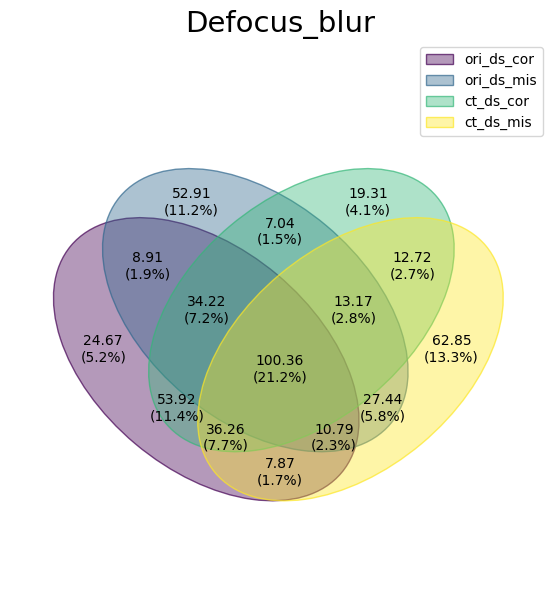

Loading cached split indices for dataset at /src/dataset/c100c_severity4/jpeg_compression/cache-8ff5f3bbe7ca43ab.arrow and /src/dataset/c100c_severity4/jpeg_compression/cache-cd1407a622bf6f8a.arrow


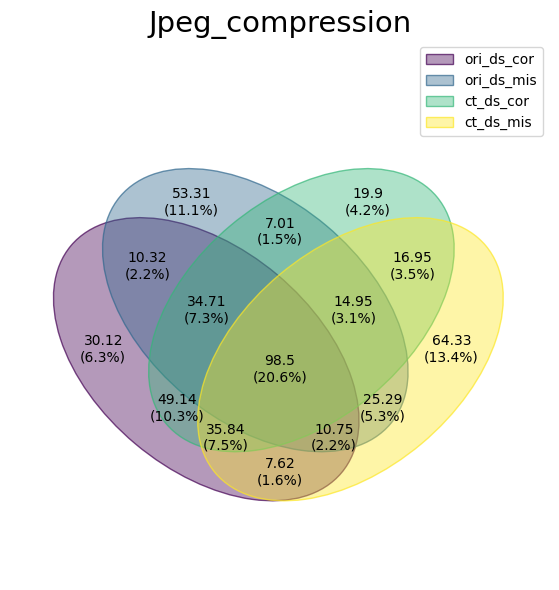

Loading cached split indices for dataset at /src/dataset/c100c_severity4/zoom_blur/cache-82b8381e5e56771e.arrow and /src/dataset/c100c_severity4/zoom_blur/cache-0de5faa498e15872.arrow


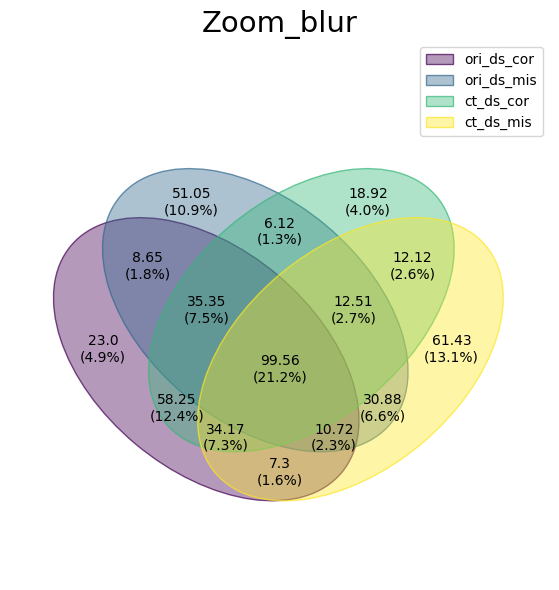

Loading cached split indices for dataset at /src/dataset/c100c_severity4/gaussian_noise/cache-7c57d212cce76083.arrow and /src/dataset/c100c_severity4/gaussian_noise/cache-4e4111d70ce3e080.arrow


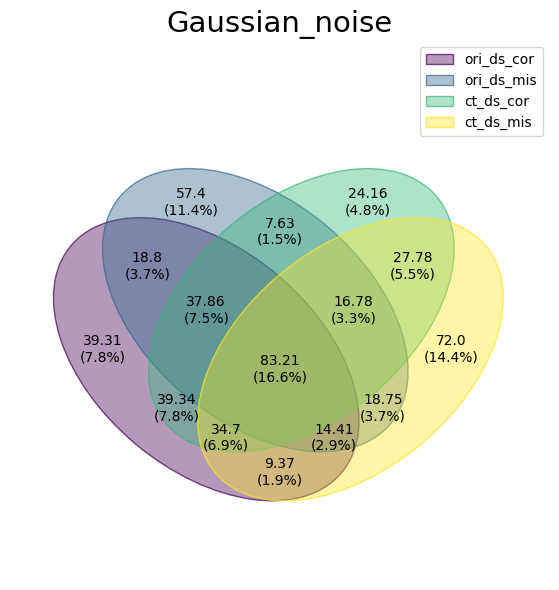

Loading cached split indices for dataset at /src/dataset/c100c_severity4/gaussian_blur/cache-116918f8b7f232de.arrow and /src/dataset/c100c_severity4/gaussian_blur/cache-67c9ee566438a573.arrow


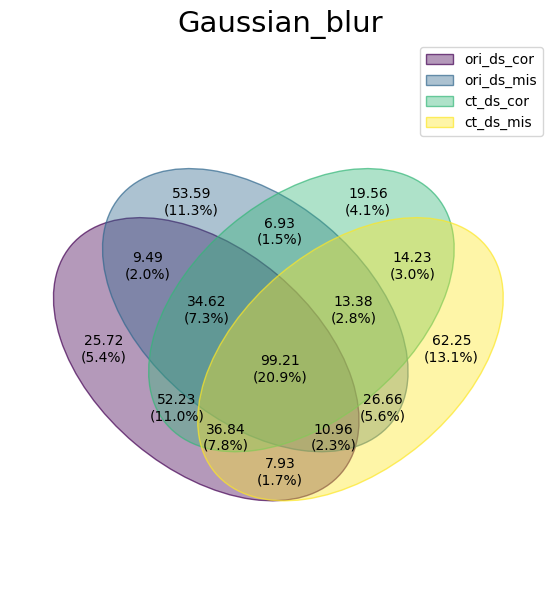

Loading cached split indices for dataset at /src/dataset/c100c_severity4/spatter/cache-d8dfe42d16533f9c.arrow and /src/dataset/c100c_severity4/spatter/cache-deb52775f7290462.arrow


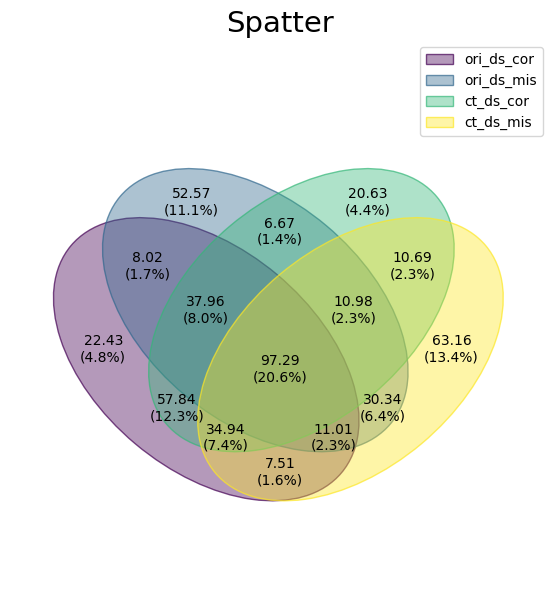

Loading cached split indices for dataset at /src/dataset/c100c_severity4/contrast/cache-288bd506081c8b48.arrow and /src/dataset/c100c_severity4/contrast/cache-6230dbe3d9fc5165.arrow


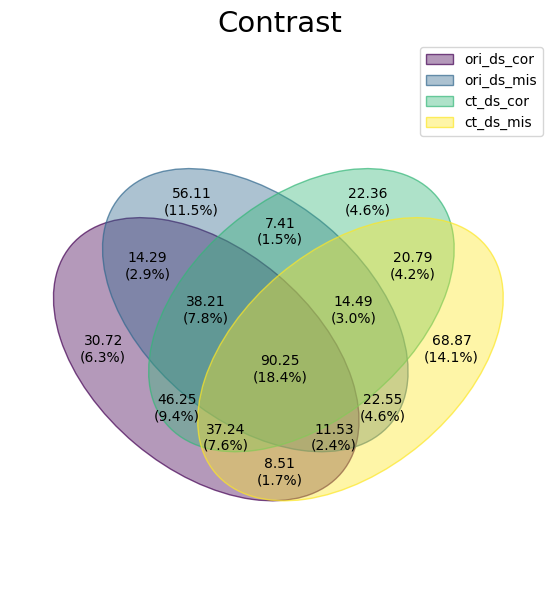

Loading cached split indices for dataset at /src/dataset/c100c_severity4/brightness/cache-a822b67c0305590e.arrow and /src/dataset/c100c_severity4/brightness/cache-ba3cc6a6b9f8fadc.arrow


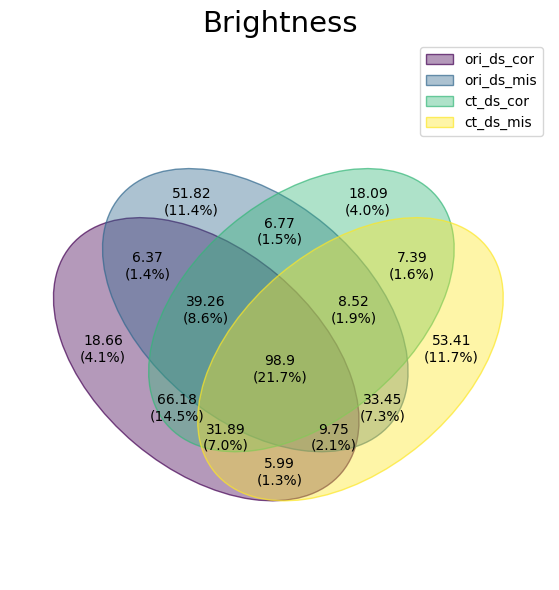

Loading cached split indices for dataset at /src/dataset/c100c_severity4/shot_noise/cache-62656b29ec460427.arrow and /src/dataset/c100c_severity4/shot_noise/cache-ccb7a741399d3a1a.arrow


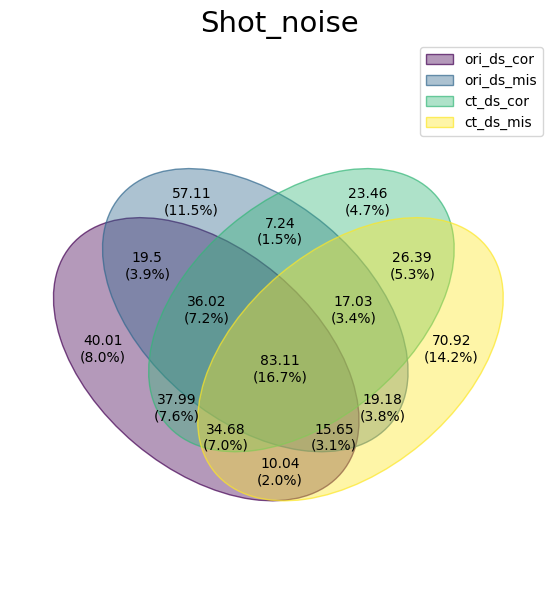

Loading cached split indices for dataset at /src/dataset/c100c_severity4/snow/cache-5b9be5d9a08a52ca.arrow and /src/dataset/c100c_severity4/snow/cache-624768f6fd0f69d1.arrow


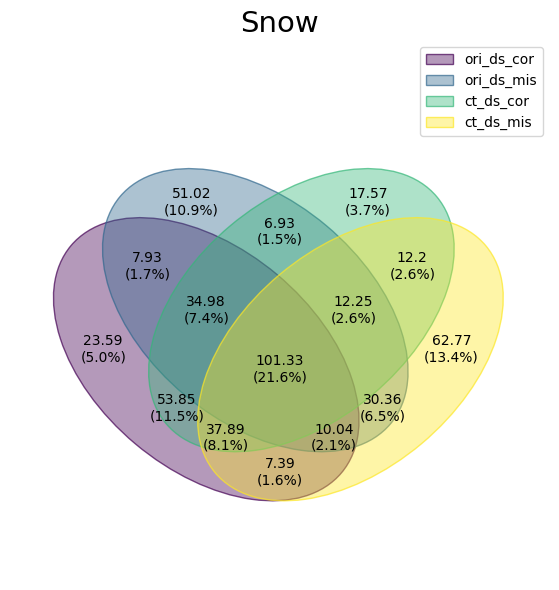

Loading cached split indices for dataset at /src/dataset/c100c_severity4/frost/cache-83440a03d8829c23.arrow and /src/dataset/c100c_severity4/frost/cache-c843638b48153776.arrow


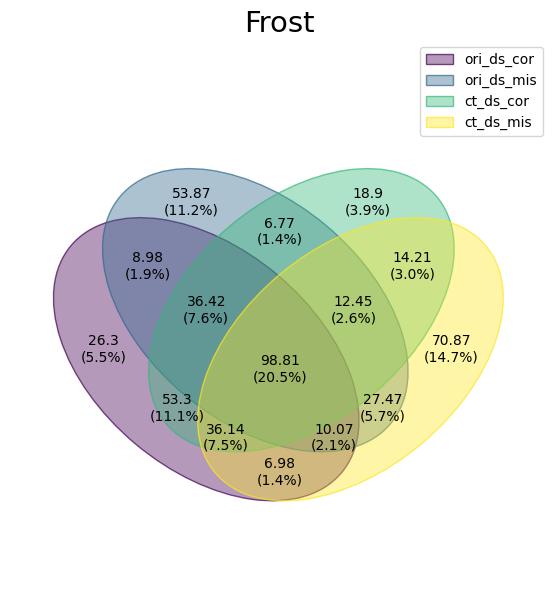

Loading cached split indices for dataset at /src/dataset/c100c_severity4/fog/cache-f2bc9f806eb324b5.arrow and /src/dataset/c100c_severity4/fog/cache-fcb0e0937dbd89b2.arrow


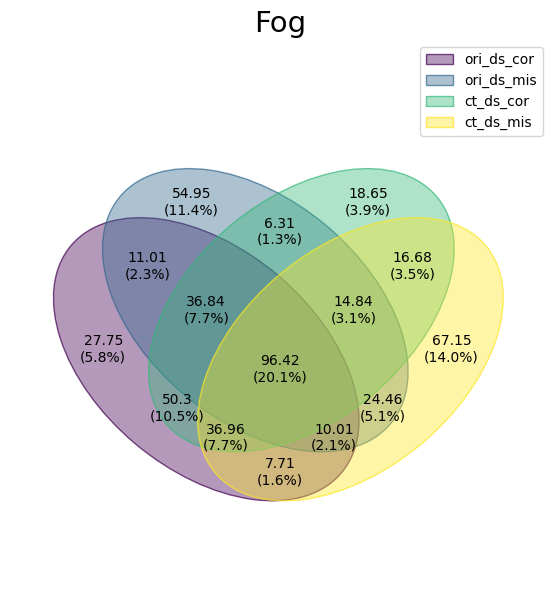

Loading cached split indices for dataset at /src/dataset/c100c_severity4/motion_blur/cache-39d45facdcf43d09.arrow and /src/dataset/c100c_severity4/motion_blur/cache-a503fe886af7b00b.arrow


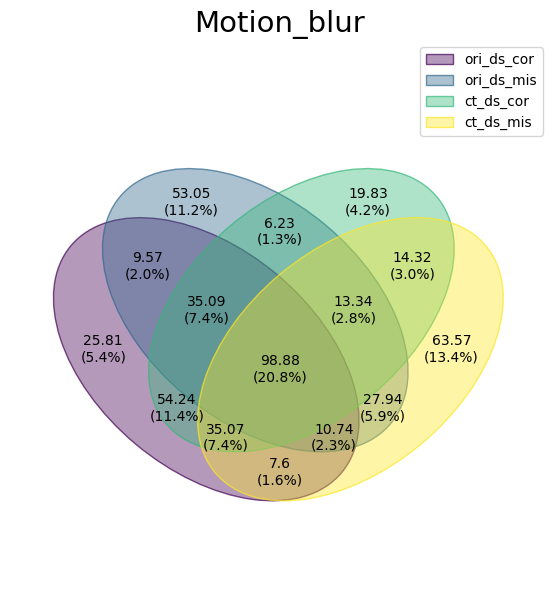

Loading cached split indices for dataset at /src/dataset/c100c_severity4/saturate/cache-a94da634012570b2.arrow and /src/dataset/c100c_severity4/saturate/cache-41a575daec3dbd4a.arrow


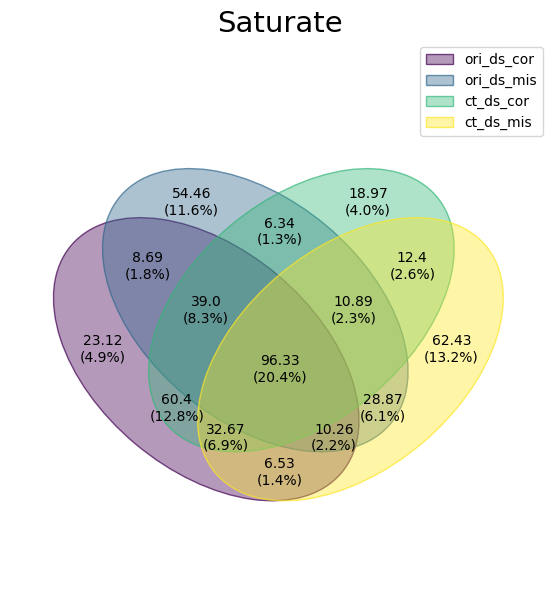

Loading cached split indices for dataset at /src/dataset/c100c_severity4/pixelate/cache-4c32d36905aa913b.arrow and /src/dataset/c100c_severity4/pixelate/cache-93869536119674fd.arrow


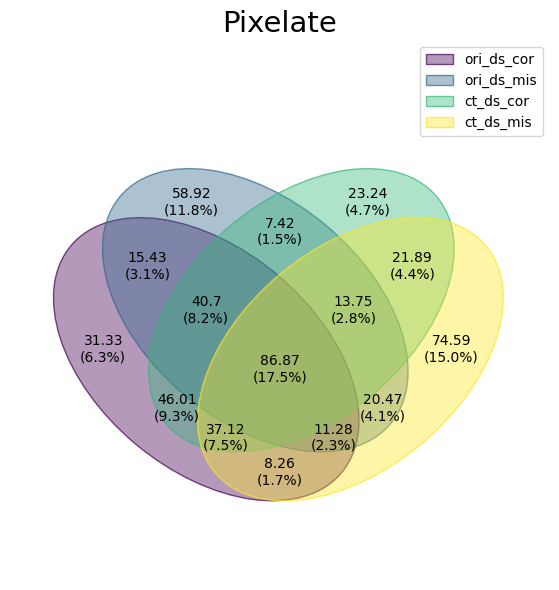

Loading cached split indices for dataset at /src/dataset/c100c_severity4/impulse_noise/cache-d85692d8097cc4da.arrow and /src/dataset/c100c_severity4/impulse_noise/cache-d747901d9bececfd.arrow


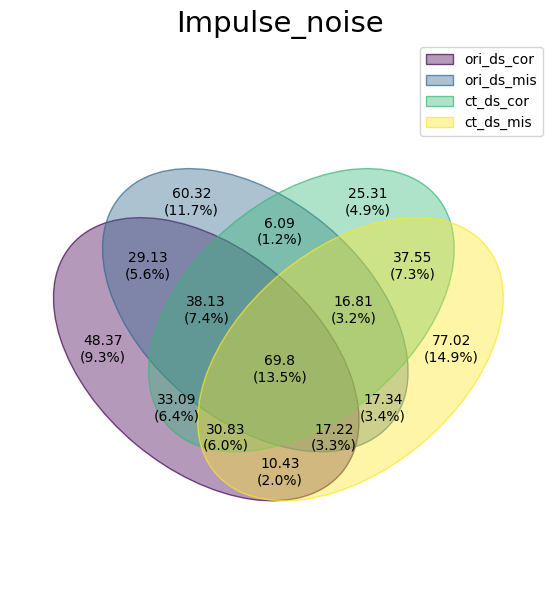

Loading cached split indices for dataset at /src/dataset/c100c_severity4/elastic_transform/cache-a3ecd87f64f1ee34.arrow and /src/dataset/c100c_severity4/elastic_transform/cache-b5e07b5372d9af80.arrow


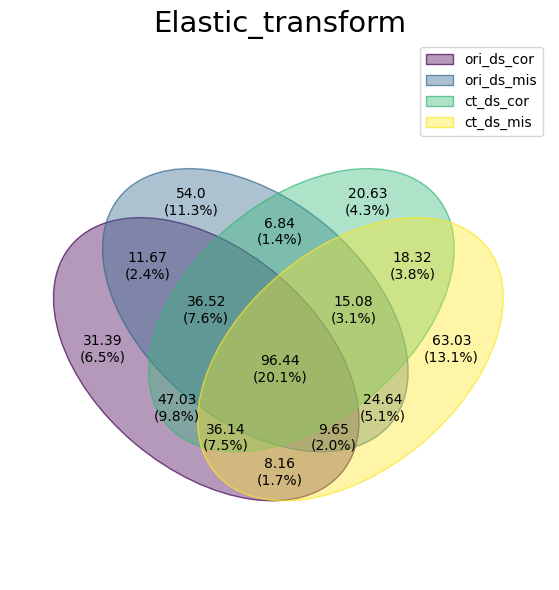

Loading cached split indices for dataset at /src/dataset/c100c_severity4/glass_blur/cache-ef330a0bf27db751.arrow and /src/dataset/c100c_severity4/glass_blur/cache-5348120e313a2c84.arrow


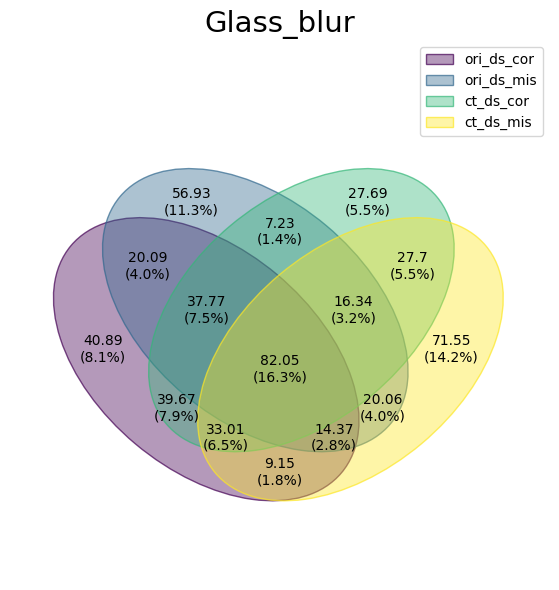

Loading cached split indices for dataset at /src/dataset/c100c_severity4/speckle_noise/cache-aeb557771e9f6780.arrow and /src/dataset/c100c_severity4/speckle_noise/cache-0e0833f727629d9c.arrow


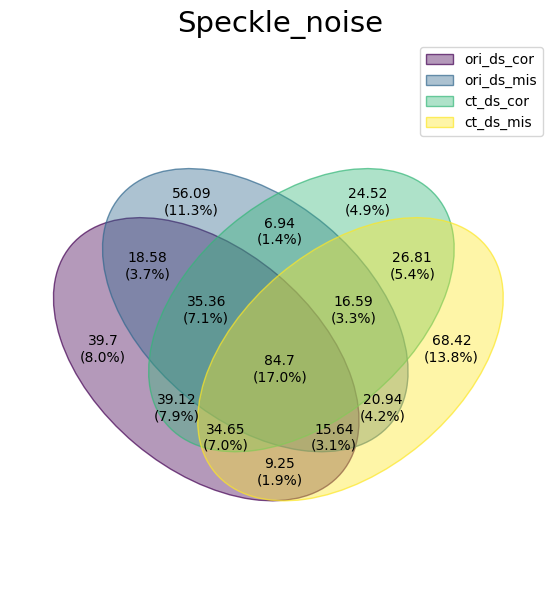

***** Costing time: 11.3051 seconds *****


In [42]:
# datasetごとに違う変数のセット
if ori_ds_name == "c10":
    tf_func = transforms
    label_col = "label"
    num_labels = 10
elif ori_ds_name == "c100":
    tf_func = transforms_c100
    label_col = "fine_label"
    num_labels = 100
else:
    NotImplementedError

# デバイス (cuda, or cpu) の取得
device = get_device()
# get corruption types
ct_list = get_corruption_types()
# original datasetをロード
ori_ds = load_from_disk(os.path.join(ViTExperiment.DATASET_DIR, ori_ds_name))[used_column]
ori_labels = np.array(ori_ds[label_col])
ori_ds = ori_ds.with_transform(tf_func)
result_dir = os.path.join(getattr(ViTExperiment, ori_ds_name).OUTPUT_DIR, "neuron_scores")
# 対象レイヤの設定
start_li = start_layer_idx
end_li = 12 # NOTE: hard coding (because dont want to load model)

tic = time.perf_counter()
# 各ノイズに対する繰り返し
for tgt_ct in ct_list:
    # tgt_ctに対するcorruption datasetをロード
    ds = load_from_disk(os.path.join(ViTExperiment.DATASET_DIR, f"{ori_ds_name}c_severity{severity}", tgt_ct))
    # train, testに分ける
    ds_split = ds.train_test_split(test_size=0.4, shuffle=True, seed=777)[used_column] # XXX: !SEEDは絶対固定!
    labels = np.array(ds_split[label_col])
    ct_ds = ds_split.with_transform(tf_func)

    # loop for each label
    petal_labels = {}
    for tgt_label in range(num_labels):
        vn_pos_dict = {}
        # 正常/ノイズデータに対するloop
        for ds_name, ds, ls in zip(["ori_ds", "ct_ds"], [ori_ds, ct_ds], [ori_labels, labels]):
            # 正解/不正解データに対するloop
            for cor_mis in ["cor", "mis"]:
                ds_type = f"ori_{used_column}" if ds_name == "ori_ds" else f"{tgt_ct}_{used_column}"
                vscore_save_path = os.path.join(result_dir, f"vscore_l{start_li}tol{end_li}_{tgt_label}_{ds_type}_{cor_mis}.json")
                with open(vscore_save_path, "r") as f:
                    vn_pos_dict[f"{ds_name}_{cor_mis}"] = json.load(f)["kn"]
                    # list of list -> set of tupleに変換
                    vn_pos_dict[f"{ds_name}_{cor_mis}"] = {(int(k), int(v)) for k, v in vn_pos_dict[f"{ds_name}_{cor_mis}"]}
        tmp_petal_labels = generate_petal_labels(vn_pos_dict.values(), fmt="{size}")
        if len(petal_labels) == 0:
            petal_labels = dict.fromkeys(tmp_petal_labels, 0)
        # tmp_petal_labelsの各値をfloatに直す
        tmp_petal_labels = {
            k: float(v) for k, v in tmp_petal_labels.items()
        }
        petal_labels = {key: petal_labels[key] + tmp_petal_labels[key] for key in petal_labels}
    sum_petal = sum(petal_labels.values())
    # petal_labelsの各値を/100する
    petal_labels = {
        k: f"{v/100}\n({100 * v/sum_petal:.1f}%)" for k, v in petal_labels.items()
    }
    figsize = (6, 6)
    fig, ax = plt.subplots(figsize=figsize)
    # print(petal_labels)
    draw_venn(
        petal_labels=petal_labels, dataset_labels=vn_pos_dict.keys(),
        hint_hidden=False, colors=generate_colors(n_colors=len(vn_pos_dict.keys())),
        figsize=figsize, fontsize=10, legend_loc="upper right", ax=ax
    )
    ax.set_title(tgt_ct.capitalize(), fontsize=21)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"./{tgt_ct}.pdf", dpi=300)



toc = time.perf_counter()
print(f"***** Costing time: {toc - tic:0.4f} seconds *****")


2の4乗-1=15個の領域ごとにv-neuronの数を出せる．

よってこれを全ラベルで平均した値でベン図を書けば, ノイズ数分 (=19) のベン図が得られる．